---

[//]: # "Header"

<p style="text-align: left;  font-size:18pt; LINE-HEIGHT:30px;">
    <span style="float: left">
     Technische Hochschule Ingolstadt<br>
     Prof. Dr. Sören Gröttrup
    </span>
    <span style="float: right;">
       Machine Learning 2<br>
        <span style="float: right;">SS 2025</span>
    </span>
</p>

[//]: # "Header Aufgabenblatt"
<br>
<p style="text-align: center;  font-size:18pt; LINE-HEIGHT:30px;">
     <span style="font-weight: bold;">Aufgabenblatt 3</span><br>
     Themen: Weight Initialization, Batch Normalisierung<br>
     Abgabetermin: 08.05.2025<br>
     Punkte: 25
</p>


---

**Namen:** Emelie Hauck, Conrad Christoph

---

### Daten

Der Datensatz `fashion-mnist` ist ein von Zalando bereitgestellter Datensatz und enthält Bilder von Kleidungsstücken aus 10 verschiedenen Kategorien (https://github.com/zalandoresearch/fashion-mnist).

Der Datensatz besteht aus einem Trainigsdatensatz mit 60.000 Bildern und einem Testdatensatz mit 10.000 Bildern. Jedes Bild ist ein grauskaliertes 28x28 Bild und die 10 Klassen sind mit 0 bis 9 codiert. 
Die Codierung ist in der nachfolgenden Tabelle angegeben:

|Label| Description|
| --- | --- |
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot|

In [2]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import time

plt.style.use('ggplot')

## Aufgabe 1 [17 Punkte]

Ziel der Aufgabe ist es sich mit der Normalisierung der Input Variablen und der Initialisierung der Gewichte vertraut zu machen und dies zu implementieren.

1. Schreiben Sie einen Routine, welche das unten angegebene Neuronale Netz `Net()` mittels `F.nll_loss()` trainiert. Dabei soll während des Trainings die Accuracy des jeweiligen Batches in regelmäßigem Abstand berechnet und abgespeichert werden (alle `log_interval` Iterationen). Weiter soll nach jeder Epoche der Loss und die Accuracy des gesamten Testdatensatzes berechnet und abgespeichert werden. 

1. Trainieren Sie das Neuronale Netz mittels SGD auf dem Datensatz und visualisieren Sie die Ergebnisse. 

1. Beim Laden der Daten werden die Inputs automatisch auf das Intervall [0,1] skaliert. Fügen Sie beim Laden der Bilder den befehl `torchvision.transforms.Normalize(0.5, 0.5)` ein. Dieser skaliert die Inputs auf das Intervall [-1,1] und zentriert diese so. Trainieren Sie das Neuronale Netz erneut, visualisieren Sie die Ergebnisse und vergleichen es mit dem Training ohne zentrierte Inputs. Beschreiben Sie die Veränderungen (falls vorhanden). 

1. Informieren Sie sich darüber, wie man in PyTorch die Gewichte initialisieren kann. Fügen Sie dann dem Neuronalen Netz eine geeignete Initalisierung der Gewichte hinzu und trainieren Sie dieses dann erneut. Vergleichen Sie es mit den anderen Trainingverläufen und visualisieren Sie diese. 

1. Informieren Sie sich, wie man in PyTorch Batch-Normalisierung hinzufügen kann. Fügen Sie dem Netz an den geeigneten Stellen Batch-Normalisierung hinzu und trainieren Sie dieses erneut. Vergleichen Sie es mit den anderen Trainigsverläufen und visualisieren Sie diese. 
_Hinweis:_ Sie können das Training beschleunigen, in dem Sie im DataLoader die Option `num_workers` auf eine positive Zahl setzen (z.B. `num_workers=4`). Dies beschleunigt das Laden der einzelnen Daten für die Mini-Batches. Mehr Informationen hier: https://pytorch.org/docs/stable/data.html

## Parameter

In [3]:
# Paths
download_data_to_folder = "../Data/"


batch_size = 64
batch_size_test = 1000

log_interval = 200
n_epochs = 10

learning_rate = 0.001

## Load data

In [4]:
# Load train data MNIST

# Define Transformer (ToTensor() is a must)
transformer = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
])

# Define data to download
train_data = torchvision.datasets.FashionMNIST(download_data_to_folder, train=True, download=True, transform=transformer)
test_data = torchvision.datasets.FashionMNIST(download_data_to_folder, train=False, download=True, transform=transformer)

################################
# Load train data with normalize

transformer_norm = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Define data to download
train_data_norm = torchvision.datasets.FashionMNIST(download_data_to_folder, train=True, download=True, transform=transformer_norm)
test_data_norm = torchvision.datasets.FashionMNIST(download_data_to_folder, train=False, download=True, transform=transformer_norm)

# loader init
train_loader_norm = torch.utils.data.DataLoader(
  train_data_norm,
  batch_size=batch_size, shuffle=True)

test_loader_norm = torch.utils.data.DataLoader(
  test_data_norm,
  batch_size=batch_size_test, shuffle=False)

In [5]:
# Download data in one batch!
train_loader = torch.utils.data.DataLoader(
  train_data,
  batch_size=batch_size, shuffle=True)

In [6]:
# Test Loader
test_loader = torch.utils.data.DataLoader(
  test_data,
  batch_size=batch_size_test, shuffle=False)

In [7]:
# Initialize iterator
train_iter = iter(train_loader)
data, targets = next(train_iter)

In [8]:
input_size = train_data[1][0].view(-1).shape[0]
print("Number of input variables (pixel):", input_size)

Number of input variables (pixel): 784


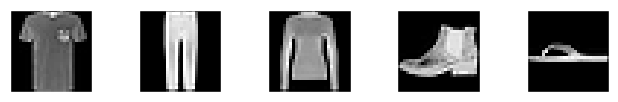

In [9]:
# Plot images
n = 5 # number of images
start_pos = 0
for i in range(n):
  plt.subplot(1, n, i+1)
  plt.tight_layout()
  plt.imshow(data[i+start_pos][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
plt.show()

## Neuronal Net

In [10]:
# Definition of the net structure
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.input_size = input_size
        
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)
    
# Definition of the new net structure
class NetBatchNorm(nn.Module):
    def __init__(self, input_size):
        super(NetBatchNorm, self).__init__()
        self.input_size = input_size
        
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, input_size)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

## Beginn Ihrer Lösung

**Train and Test Funktionen**

In [11]:
# Training function for each epoch

def train(network, log_interval, train_loader, optimizer):
  train_acc = []  
  network.train()

  for batch_idx, (x, y) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(x)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      pred = output.argmax(dim=1, keepdim=True)
      correct = pred.eq(y.view_as(pred)).sum().item()
      acc = correct / len(data)
      train_acc.append(acc)
  return train_acc



In [12]:
# Test function that applies the test set to the trained net

def test(network, test_loader):
  test_losses = []
  test_acc = []
  correct = 0
  
  network.eval()  
  test_loss = 0
  with torch.no_grad():
    for x_test, y_test in test_loader:
      output = network(x_test)
      test_loss += F.nll_loss(output, y_test).item()
      pred = output.argmax(dim=1, keepdim=True)
      pred = pred.view(pred.size(0))
      correct += pred.eq(y_test).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(accuracy)

    return test_loss,test_acc 

  
    
  
    

**Run training**

Baseline without Normalization / centered Inputs


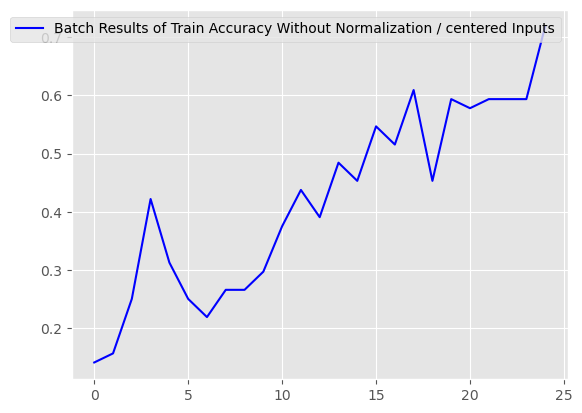

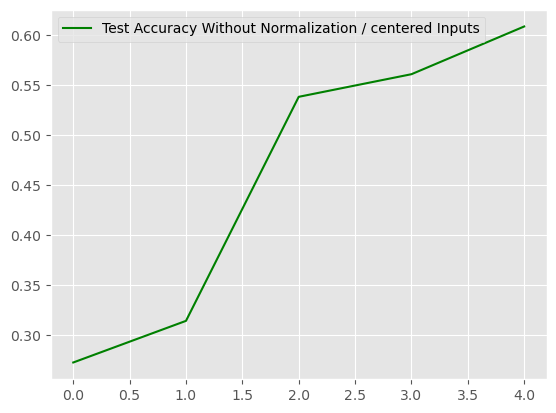

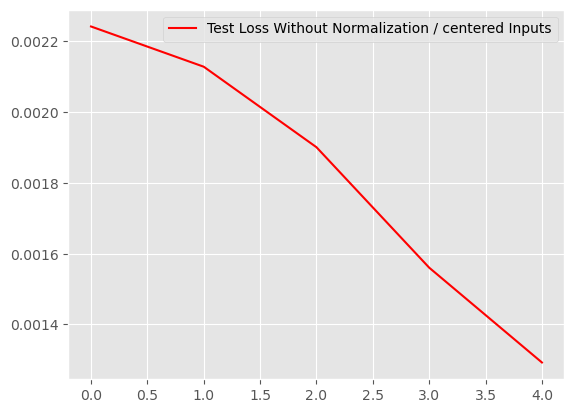

With Normalization / centered Inputs


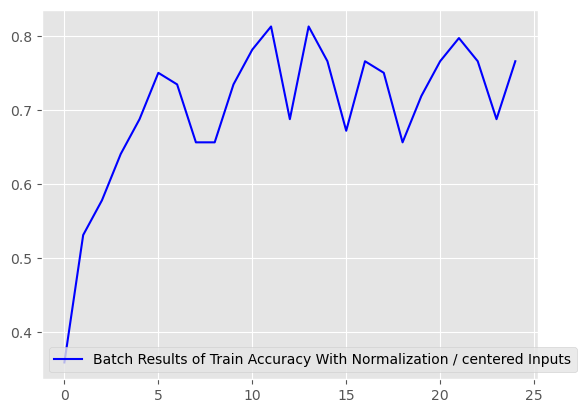

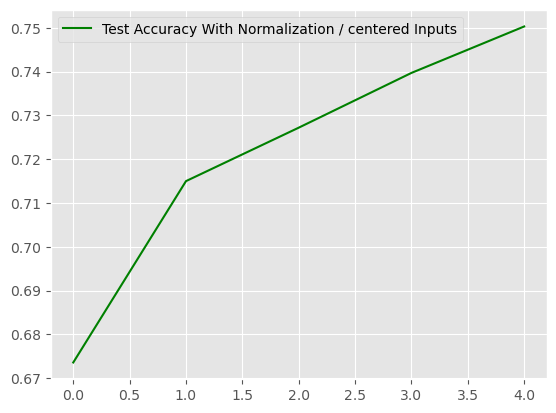

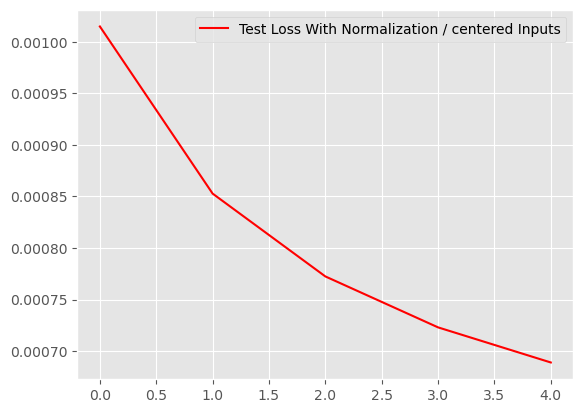

With Initial Weights


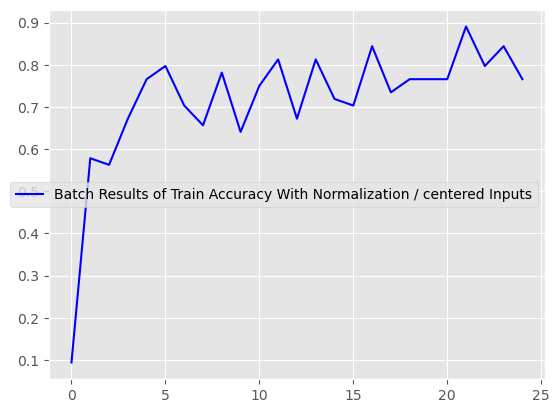

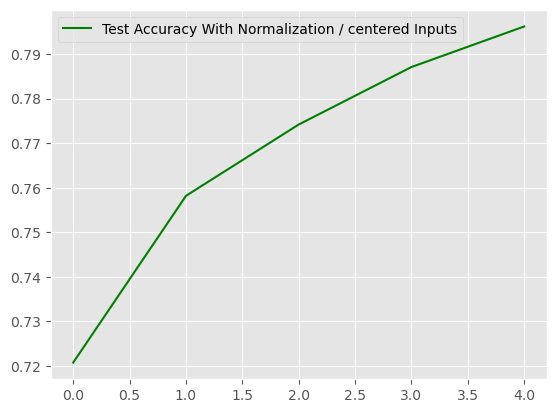

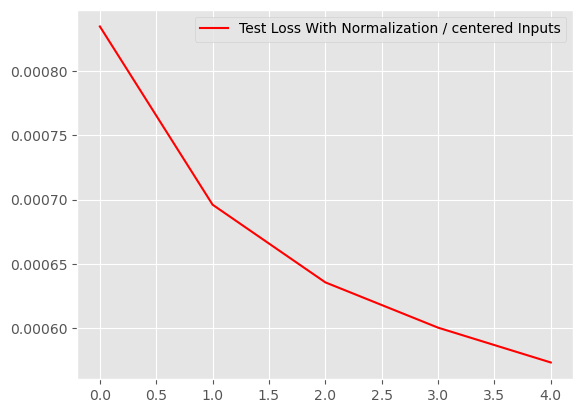

With Batch Normalization


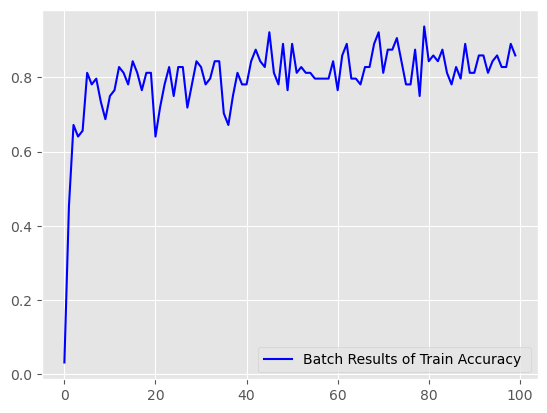

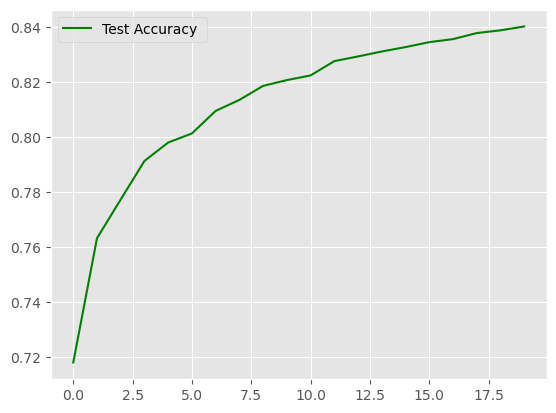

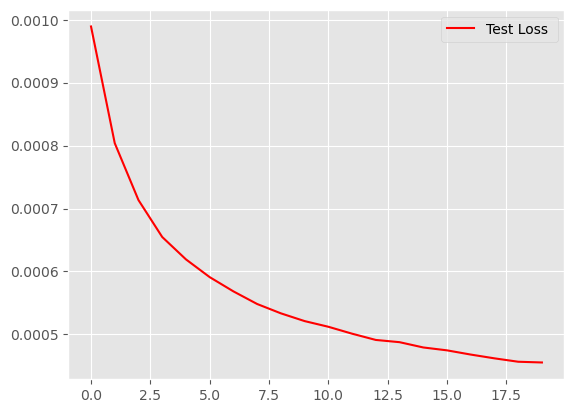

In [13]:
def run_nn(network, train_loader, test_loader, n_epochs, normalization_string, optimizer):
    batch_acc_results = []
    test_acc = []
    test_loss = []
    
    for epoch in range(n_epochs):
        batch_acc_results.extend(train(network, log_interval, train_loader, optimizer))
        a,b = test(network, test_loader)
        test_loss.append(a)
        test_acc.extend(b)
    plt.plot(batch_acc_results, label=f"Batch Results of Train Accuracy {normalization_string}", color="blue")
    plt.legend()
    plt.show()
    plt.plot(test_acc, label=f"Test Accuracy {normalization_string}", color="green")
    plt.legend()
    plt.show()
    plt.plot(test_loss, label=f"Test Loss {normalization_string}", color="red")
    plt.legend()
    plt.show()
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.fill_(0.01)


model = Net(input_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print("Baseline without Normalization / centered Inputs")
run_nn(model, train_loader,test_loader,5, "Without Normalization / centered Inputs", optimizer)
print("With Normalization / centered Inputs")
run_nn(model, train_loader_norm, test_loader_norm,5, "With Normalization / centered Inputs", optimizer)

print("With Initial Weights")
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
run_nn(model, train_loader_norm, test_loader_norm,5, "With Normalization / centered Inputs", optimizer)

print("With Batch Normalization")
model_batch_norm = NetBatchNorm(input_size)
optimizer = optim.SGD(model_batch_norm.parameters(), lr=learning_rate)
model_batch_norm.apply(init_weights)

run_nn(model_batch_norm, train_loader_norm, test_loader_norm, 20, "", optimizer)

|Kategorie|Baseline SGD|Centered Inputs|Initial Weights| Batch Normalization|
|---|---|---|---|---|
|Train Accuracy|langsamer Anstieg über 5 Epochen; flache Kurve; höchter Wert danach bei 0,7|steilere Kurve; höchter Wert danach bei 0,8|steilere Kurve; höchter Wert danach bei 0,83|steilere Kurve; höchter Wert danach bei 0,85|
|Test Accuracy|langsamer Anstieg über 5 Epochen; flache Kurve; höchter Wert danach bei 0,6|steilere Kurve; höchter Wert danach bei 0,75|steilere Kurve; höchter Wert danach bei 0,79|steilere Kurve; höchter Wert danach bei 0,84|
|Test Loss|flache Linear sinkende Kurve; niedrigster Wert nach 5 Epochen bei 0,0013|steilere Kurve; niedrigster Wert nach 5 Epochen bei 0,0007|steilere Kurve; niedrigster Wert nach 5 Epochen bei 0,00055|steilere Kurve; niedrigster Wert nach 5 Epochen bei 0,00045|

Zusammenfassend lässt sich sagen, dass die Ergebnisse bei Anwendung von mehr Methoden zur Verbesserung des Trainings besser werden. Dies drückt sich durch steilere Kurven sowohl steiler steigend bei der Accuracy als auch steiler fallend beim Loss und durch bessere Endwert für Loss & Accuracy aus.



## Aufgabe 2 [8 Punkte]

Trainieren Sie nun das Neuronale Netze aus Aufgabe 1 Teil 4 (mit Weight Initialization) und trainieren dies 

1. mit Momentum
1. mit Adam

jeweils mit den Default Parametern. Hat sich etwas am Trainingsverlauf geändert?


## Beginn Ihrer Lösung

With Momentum


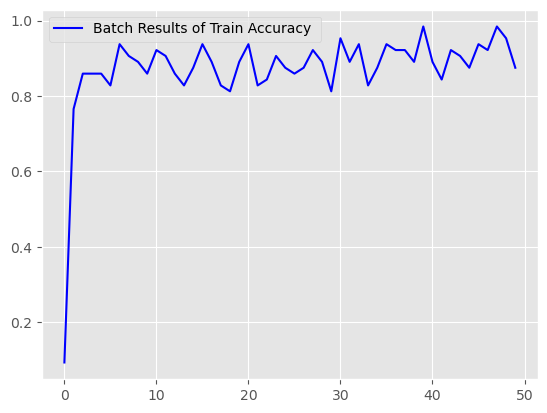

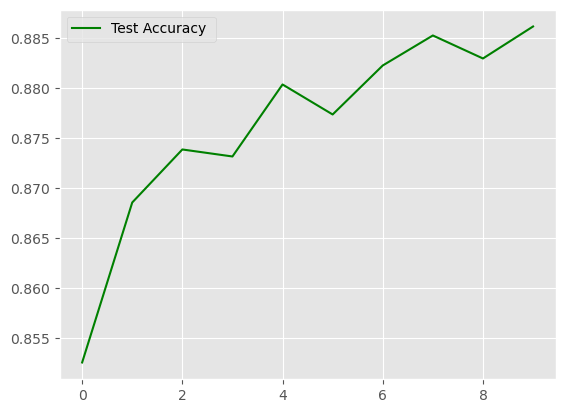

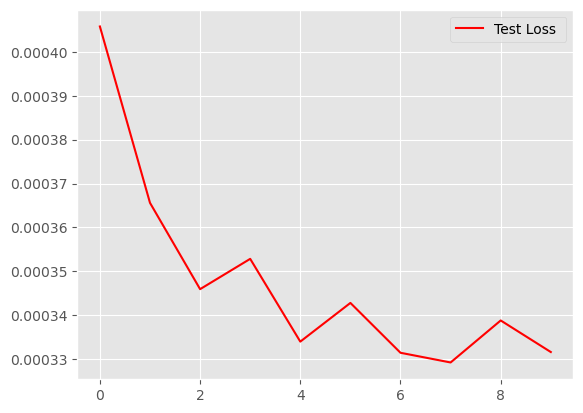

With Adam


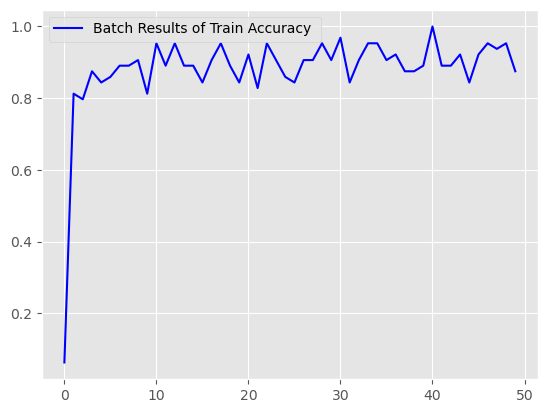

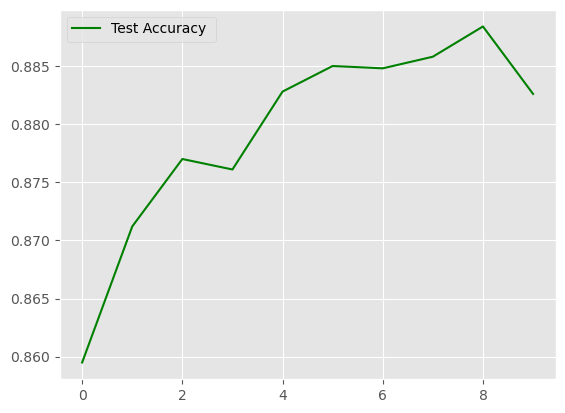

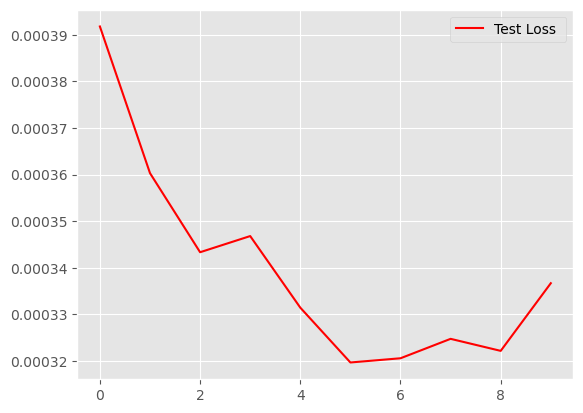

In [14]:
print("With Momentum")
model_batch_norm = NetBatchNorm(input_size)
optimizer = optim.SGD(model_batch_norm.parameters(), lr=0.01, momentum=0.9)
model_batch_norm.apply(init_weights)

run_nn(model_batch_norm, train_loader_norm, test_loader_norm, 10, "", optimizer)

print("With Adam")
model_batch_norm = NetBatchNorm(input_size)
optimizer = optim.Adam(model_batch_norm.parameters(), lr=0.001)
model_batch_norm.apply(init_weights)

run_nn(model_batch_norm, train_loader_norm, test_loader_norm, 10, "", optimizer)

Erneut lässt sich eine Verbesserung der Trainings- und Testkurven beobachten. Besonders die Trainingsaccuracy steigt erheblich schneller, wie es von Momentum & Adam gegenüber SGD auch zu erwarten ist. Auch die Endwerte sind wieder besser als bei SGD (annähernd 1 für Test Accuracy zu maximal 0,85 bei SGD; 0,885 Test Accuracy zu 0,84 bei SGD; kleinster Loss unter 0,0004 zu 0,00045 bei SGD)